# 3D House project

This project consists of plotting an interactive 3D Surface Graph of a house, based on the address provided. The region covered is the region of Flanders (Belgium).

The data are *Lidar* data. The region is divided into 43 rasters. Each raster is in the format **.tif** . This program will select the correct raster after getting from an API the geospatial coordinates corresponding to the address of the house.

## 1. Libraries

In [18]:
import geopandas as gpd
from shapely.geometry import Polygon

import rasterio # Tif files
import os
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
from plotly.graph_objs import *
from rasterio.plot import show
from rasterio.mask import mask

import requests
import json

## 2. Address and coordinates

In [19]:
post_code = int(input("Post code: "))

Post code:  9051


In [20]:
street_name = input("Street name: ")

Street name:  maaltekouter


In [21]:
house_number = int(input("House number: "))

House number:  1


In [22]:
house_address = f'{street_name} {house_number} {post_code}' # Will be use for the title of the 3D plot later on

In [23]:
# Address request to the basisregisters Vlaanderen API

# HTTP request to the API
address = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch",
                      params={'postcode': post_code, 'straatnaam': street_name, 'huisnummer':house_number})

address = address.json() # Convert http request's response into json format

In [24]:
def get_coordinates(address):
    """
    Function that get the geospatial coordinates and separate the latitude and longitude
    in two different lists (lat, lon).
    """

    address = address['adresMatches'][0]
    
    norm = pd.json_normalize(address)
    norm = norm.loc[0,'adresseerbareObjecten']
    block_url = norm[0].get('detail')
    block_url
    
    # Second request
    address = requests.get(block_url)
    block_details = address.json()
    block_details
    
    building = block_details.get('gebouw')
    url_house = building.get('detail')
    
    # Third request
    house = requests.get(url_house)
    house_details = house.json()


    df = pd.json_normalize(house_details) # Convert the json format into a Pandas DataFrame
    
    house_coordinates = df.loc[0,'geometriePolygoon.polygon.coordinates']
    lat_lon = []

    # Write geometry coordinates to a list
    for list in house_coordinates:
        for sublist in list:
            for coordinates in sublist:
                print(coordinates, end='\n')
                lat_lon.append(coordinates)

    lat = []
    lon = []

    for i, coords in enumerate(lat_lon):
        if i % 2 == 0:
            lat.append(coords)
        else:
            lon.append(coords)

    return lat, lon

In [25]:
lat, lon = get_coordinates(address)

102461.71434639394
191116.0521667041
102437.88996237516
191074.20691867545
102494.97796241939
191041.64679065347
102483.17687440664
191020.79456663877
102425.9721383676
191053.51290266216
102402.014122352
191011.73114263266
102410.08017035574
191007.21018262953
102406.76292235404
191001.74304662645
102409.20209036022
191000.4220866263
102403.72317835689
190990.82413461804
102401.32189834863
190992.10515861958
102398.32106634974
190986.55507861823
102390.2150823474
190991.15488661826
102366.33489032835
190949.17600658908
102371.41188233346
190946.41376658902
102368.25386632979
190941.2210625857
102371.5188903287
190939.38195858523
102370.87991432846
190938.28115858138
102373.67287433147
190936.68013458326
102373.27300233394
190935.9730625823
102377.3628583327
190933.45504657924
102377.9219623357
190934.2409665808
102380.6770343408
190932.71981457993
102381.35543433577
190933.82215058059
102391.31025034189
190928.18093457446
102394.46775434911
190933.33319057897
102439.12081037462
190907

## 3. Creation of the polygon

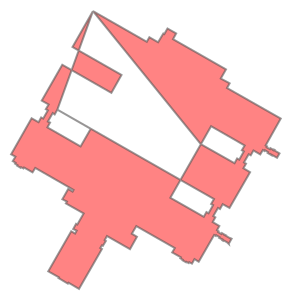

In [26]:
polygon_geometry = Polygon(zip(lat, lon)) # Geometry
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:31370', geometry=[polygon_geometry])

polygon_geometry

## 4. Selection of the raster

All the rasters are located in the local drive and separated in two distincts folders (/DSM and /DTM)

In [27]:
def select_raster(coordinates):
    """
    Function that select the correct raster based on the coordinates of the address.
    """
    
    df = pd.read_csv('rasters_lambert_coordinates.csv') # Load the csv file
    

    # Search for the correct raster
    raster = df[(df['Left'] < coordinates[0]) & (df['Right'] > coordinates[0])
       & ((df['Bottom'] < coordinates[1]) & (df['Top'] > coordinates[1]))]
    
    num_raster = raster['Raster'].item() # Raster number
    
    return num_raster

In [28]:
# Return raster number
raster_number = select_raster([lat[0],lon[0]])

## 5. Masking the DSM and DTM

In [29]:
path_DSM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DSM/DHMVIIDSMRAS1m_k{raster_number}.tif"  
path_DTM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DTM/DHMVIIDTMRAS1m_k{raster_number}.tif"
path_DSM

# Open DTM and DSM rasters
raster_DTM = rasterio.open(path_DTM)
raster_DSM = rasterio.open(path_DSM)


# Crop of the DTM raster based on the polygon geometry
masked_DTM, masked_transform_DTM = mask(dataset=raster_DTM, shapes=polygon.geometry, crop=True, filled=False) 


# Crop of the DSM raster based on the polygon geometry
masked_DSM, masked_transform_DSM = mask(dataset=raster_DSM, shapes=polygon.geometry, crop=True, filled=False) 

profile = raster_DTM.meta.copy()

width = masked_DTM.shape[2]
height = masked_DTM.shape[1]
profile.update(drivers='GTiff', transform=masked_transform_DTM, height=height, width=width)

print(profile)

# Create a new file "masked_DSM.tif" and saving it into the local drive
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DSM.tif", 'w', **profile) as dst:
    dst.write(masked_DSM) 
    
# Create a new file "masked_DTM.tif" and saving it into the local drive    
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DTM.tif", 'w', **profile) as dst:
    dst.write(masked_DTM) # Save the masked DTM

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 315, 'height': 325, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 102366.0,
       0.0, -1.0, 191117.0), 'drivers': 'GTiff'}


## 6. Creation of the CHM (Canopy Height Model)

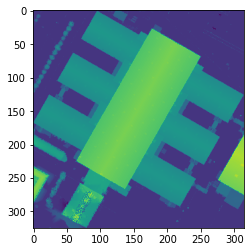

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 315, 'height': 325, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 102366.0,
       0.0, -1.0, 191117.0), 'drivers': 'GTiff'}


In [30]:
m_DTM = rasterio.open('masked_DTM.tif')
m_DSM = rasterio.open('masked_DSM.tif')

DSM_array = m_DSM.read(1)
DTM_array = m_DTM.read(1)
raster_CHM = DSM_array - DTM_array # Canopy Height Model (CHM) = (DSM - DTM)
show(raster_CHM)

print(profile)

# # Create a new file "CHM.tif" and save it into the local drive
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/CHM.tif", 'w', **profile) as dst:
    dst.write(raster_CHM, 1)

## 7. 3D Plot

The library used is **plotly**. The 3D Surface plot opens in the browser in a new tab.

In [32]:
CHM = rasterio.open('CHM.tif')
CHM_array = CHM.read(1) # Convert the raster into a Numpy array



# Reversing axis to get the correct shape
import gdal
from mpl_toolkits.mplot3d import Axes3D
dem = gdal.Open("CHM.tif")
gt  = dem.GetGeoTransform()
dem = dem.ReadAsArray()
xres = gt[1]
yres = gt[5]
X = np.arange(gt[0], gt[0] + dem.shape[1]*xres, xres)
Y = np.arange(gt[3], gt[3] + dem.shape[0]*yres, yres)

#Plot
fig = go.Figure(data=[go.Surface(z=CHM_array, x=X, y=Y)]) # Create the figure from the CHM array
fig.update_layout(title=f'3D Plot - {house_address} (BeCode Beacon Campus)',
                    scene = dict(
                    xaxis_title='Distance (m)',
                    yaxis_title='Distance (m)',
                    zaxis_title='Height'),
                    font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="RebeccaPurple"))

#fig.write_image("image.png", width=1000, height=1000) # Write image to the local drive

plot(fig) # Plot the house in new tab

'temp-plot.html'


<img src='3D Plot images/Becode Beacon campus.png' width="900" height="900">